In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_strings_data(str_len=5):
    strings = []
    for i in range(2**str_len):
        bit_repr = "{0:b}".format(i).zfill(5)
        ones = bit_repr.count('1')
        strings.append((bit_repr, ones))
        
    idx_to_string = {i:string for i,string in enumerate(strings)} 
    string_to_idx = {string:i for i,string in enumerate(strings)}
    idx_to_key, idx_to_query = idx_to_string, idx_to_string
    key_to_idx, query_to_idx = string_to_idx, string_to_idx
    
    query_to_keys = {}
    for i in range(len(idx_to_key)):
        for j in range(len(idx_to_query)):
            if idx_to_string[i][1] == idx_to_string[j][1]: # match
                if j not in query_to_keys: # start new list
                    query_to_keys[j] = {}
                query_to_keys[j][i] = idx_to_string[j][1] # idx, num matches
    
    data = {
        'idx_to_key': idx_to_key,
        'key_to_idx': key_to_idx,
        'idx_to_query': idx_to_query,
        'query_to_idx': query_to_idx,
        'query_to_keys': query_to_keys,
    }
    
    return data

string_length = 6
game_data = generate_strings_data(string_length)

## Data -- Distribution, Splits

In [3]:
count_table = np.zeros((2**string_length, 2**string_length))

for i in range(2**string_length):
    for j in range(2**string_length): 
        count_table[i][j] = int(game_data['idx_to_key'][i][1] == game_data['idx_to_query'][j][1])
        
xy = count_table/np.sum(count_table)
# xy += 1e-9
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
Counter(list(xy.reshape(-1))).most_common()

[(0.0, 3172), (0.0010822510822510825, 924)]

In [5]:
np.sum(count_table)

924.0

In [6]:
np.linalg.matrix_rank(xy)

7

In [7]:
np.linalg.matrix_rank((xy/xyind))

7

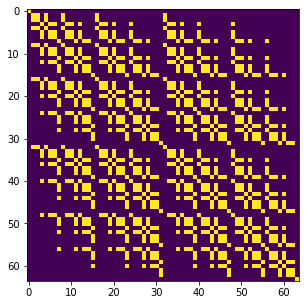

In [8]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy)[:, :])

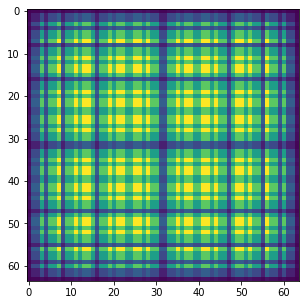

In [9]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xyind)[:, :])

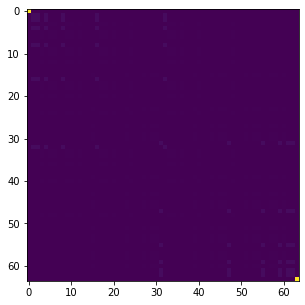

In [10]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy/xyind)[:, :300])

In [11]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.0, 3172),
 (4.106666666666667, 450),
 (2.3099999999999996, 400),
 (25.666666666666668, 72),
 (923.9999999999999, 2)]

## Dataset

In [12]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            print('query\n', y_j, self.raw_data['idx_to_query'][y_j])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[7]

query
 7 ('00111', 3)
key
 0 ('00000', 0)
all matches 
 [('00111', 3), ('01011', 3), ('01101', 3), ('01110', 3), ('10011', 3), ('10101', 3), ('10110', 3), ('11001', 3), ('11010', 3), ('11100', 3), ('100011', 3), ('100101', 3), ('100110', 3), ('101001', 3), ('101010', 3), ('101100', 3), ('110001', 3), ('110010', 3), ('110100', 3), ('111000', 3)]


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [13]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            print('query\n', y_j, self.raw_data['idx_to_query'][y_j])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[7]

query
 7 ('00111', 3)
all matches 
 [('00111', 3), ('01011', 3), ('01101', 3), ('01110', 3), ('10011', 3), ('10101', 3), ('10110', 3), ('11001', 3), ('11010', 3), ('11100', 3), ('100011', 3), ('100101', 3), ('100110', 3), ('101001', 3), ('101010', 3), ('101100', 3), ('110001', 3), ('110010', 3), ('110100', 3), ('111000', 3)]


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
        self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
        if stage == 'test' or stage is None:
            self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
    def test_dataloader(self):
        test_loader = DataLoader(
            self.test, batch_size=self.batch_size, shuffle=False
        )
        return test_loader  

## Training Module

In [15]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions, raw_data):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = ThresholdedMetrics(raw_data=raw_data)

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, test_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, test_bool, debug=debug)
        # scalar
        loss = None if test_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, breakdown_errors_bool=True, 
        ) if test_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, test_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, test_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif 'count' in m or 'rate' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics        
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, test_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if test_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
            
        error_count_by_num_matched_concepts = \
            Counter((num_matched_concepts * wrongs).reshape(-1).tolist())
        
        total_count_by_num_matched_concepts = \
            Counter((num_matched_concepts).reshape(-1).tolist())        
        
        error_counts = {f'error_rate_for_{k}_matched_concepts':error_count_by_num_matched_concepts[k]/total_count_by_num_matched_concepts[k] for k in error_count_by_num_matched_concepts.keys() if k!=0}
        total_counts = {f'total_count_for_{k}_matched_concepts':total_count_by_num_matched_concepts[k] for k in total_count_by_num_matched_concepts.keys() if k!=0}
        
        return {**error_counts, **total_counts}
        
    def forward(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)
        
        
        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by__QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## hparams, init train module

In [21]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 16,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':False,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind}, raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.6 K 
1  | model.inp_query_layer                        | Sequential         | 1.0 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 1.0 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 1.0 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.0 K 
8  | model.classifier                             | Sequential         | 545   
9  | model.classifier.linear1                     | Linear             | 528   
10 | model.classifier.nonLinear1  

## Run Training

In [22]:
# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = f'CountOnes-6digits-NonLinear;params2.6K'
project_name = 'ContrastiveLearning-cardgame-Scaling'

wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=15000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    # track_grad_norm
)

# fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


RUN NAME :
 CountOnes-6digits-NonLinear;params2.6K


<ipython-input-22-b9c6a7710d72>:31: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.6 K 
1  | model.inp_query_layer                        | Sequential         | 1.0 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 1.0 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 1.0 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 1.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 1.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 1.0 K 
8  | model.classifier                             | Sequential         | 545   
9  | model.classifier.linear1                     | Linear             | 528   
10 | model.classifier.nonLinear1 

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 

Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=621, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|████

Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=620, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=619, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=619, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=619, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 77:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=619, v_num=p5v6]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=616, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=616, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=616, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=615, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=615, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=615, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=615, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 110:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=614, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 111:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=614, v_num=p5v6]
Validating

Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=600, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=599, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=598, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=597, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=596, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=595, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=594, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=593, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 144:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=592, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 145:

Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=552, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 170:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=550, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 171:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=549, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=547, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=545, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=543, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=542, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=540, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=538, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 178:

Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=499, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=497, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=496, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=496, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=494, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=494, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=493, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 210:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=492, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 211:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=491, v_num=p5v6]
Validating

Epoch 236:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=476, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 237:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 238:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 239:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=476, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=476, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 244:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=475, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 245:

Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=469, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 277:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=468, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 278:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=468, v_num=p5v6]
Validating

Epoch 303:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=464, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 304:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=464, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 305:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=465, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 306:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=464, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 307:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=464, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 308:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=463, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=463, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 310:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=463, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 311:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=464, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 312:

Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=462, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=462, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=462, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 345:

Epoch 370:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 371:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 372:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 373:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 374:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 375:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 376:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 377:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 378:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 379:

Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=462, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 410:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 411:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 412:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 413:

Epoch 437:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 438:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 439:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 440:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 441:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 442:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 443:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 444:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 445:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 446:

Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 477:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 478:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 479:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 480:

Epoch 504:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 505:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 506:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 507:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 508:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 509:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 510:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 511:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 512:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 513:

Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 544:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 545:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 546:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=458, v_num=p5v6]
Validating

Epoch 571:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 572:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 573:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 574:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 575:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 576:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 577:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 578:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 579:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 580:

Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 610:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 611:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 612:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 613:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 614:

Validating: 0it [00:00, ?it/s]
Epoch 639:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 640:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=458, v_num=p5v6]
Validating

Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 677:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 678:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 679:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 681:

Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 710:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 711:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 712:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 713:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 714:

Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 744:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 745:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 746:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 747:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 748:

Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 777:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 778:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 779:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 780:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 781:

Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 810:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 811:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 812:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 813:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 814:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=457, v_num=p5v6]
Validating

Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 842:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 843:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 844:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 845:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 846:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 847:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 848:

Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 877:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 878:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 879:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 880:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 881:

Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 908:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 909:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 910:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 911:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 912:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 913:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 914:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 915:

Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 944:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 945:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 946:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 947:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 948:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 949:

Epoch 974:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 975:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 976:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 977:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 978:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 979:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 980:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 981:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 982:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 983:

Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1010:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1011:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1012:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1013:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1014:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1015:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1041:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1042:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1043:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1044:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1045:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1046:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1047:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1048:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1049: 100%|██████████| 2/2 [00:00<00:00,  8.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1076:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1077:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1078:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1079:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1080:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1081:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1082:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1108:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1109:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1110:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1111:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1112:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1113:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1114:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1115:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1116:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1142:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1143:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1144:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1145:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1146:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1147:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1148:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1149:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1150:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1177:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1178:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1179:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1180:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1181:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1182:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1183:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1184:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1185:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1210:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1211:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1212:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1213:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1214:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1215:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1216:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1217:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1218:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1243:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1244:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1245:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1246:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1247:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1248:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1249:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1250:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1251:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1278:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1279:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1280:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1281:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1282:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1283:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1284:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1285:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1286:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1311:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1312:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1313:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1314:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1315:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1316:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1346:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1347:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1348:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1349:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1350:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1351:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1352:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1353:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1354:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
V

Epoch 1380:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1381:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1382:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1383:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1384:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1385:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1386:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1387:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1388:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1414:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1415:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1416:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1417:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1418:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1419:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1420:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1421:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1422:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1447:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1448:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1449: 100%|██████████| 2/2 [00:00<00:00,  8.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1450:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1451:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1452:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1453:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1454:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1455:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1482:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1483:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1484:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1490:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1517:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1518:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1519:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1520:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1521:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1522:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1523:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1524:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1525:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1555:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1556:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1557:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1558:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1559:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1560:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1561:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1562:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1590:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1591:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1592:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1593:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1594:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1624:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1625:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1626:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1627:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1628:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1629:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1657:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1658:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1659:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1692:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1693:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1694:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1699:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1726:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1760:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1767:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1768:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  8.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1802:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1803:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1834:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1835:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1836:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1837:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1838:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1839:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1868:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1869:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1870:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1871:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1872:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1873:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1901:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1902:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1903:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1904:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1905:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1906:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1907:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1934:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1935:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1936:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1937:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1938:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1939:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1940:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1941:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=p5v6]
V

Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1967:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1968:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1969:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1970:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1971:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1972:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1973:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 1974:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2000:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2001:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2002:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2003:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2004:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2005:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2006:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2007:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2008:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2034:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2035:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2036:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2037:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2038:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2039:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2040:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2041:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2042:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2068:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2069:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2070:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2071:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2072:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2073:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2074:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2075:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2076:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2103:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2104:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2105:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2106:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2107:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2108:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2109:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2110:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2111:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2136:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2137:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2138:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2139:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2140:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2141:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2142:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2143:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2144:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2169:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2170:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2171:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2172:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2173:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2174:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2175:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2176:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2177:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2203:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2204:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2205:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2206:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2207:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2208:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2209:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2210:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2211:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=452, v_num=p5v6]
V

Epoch 2236:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2237:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2238:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2239:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2240:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2241:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2242:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2243:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2244:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2269:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2270:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2271:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2272:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2273:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2274:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2275:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2276:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2277:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2302:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2303:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2304:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2305:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2306:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2307:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2308:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2309:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2310:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2336:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2337:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2338:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2339:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2340:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2341:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2342:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2343:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2344:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
V

Epoch 2369:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2370:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2371:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2372:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2373:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2374:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2375:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2376:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2377:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2402:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2403:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2404:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2405:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2406:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2407:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2408:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2409:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2410:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2435:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2436:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2437:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2438:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2439:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2440:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2441:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2442:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2443:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2469:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2470:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2471:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2472:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2473:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2474:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2475:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2476:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2477:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2502:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2503:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2504:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2505:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2506:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2507:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2508:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2509:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2510:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2536:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2537:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2538:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2539:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2540:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2541:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2542:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2543:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2544:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=452, v_num=p5v6]
V

Epoch 2569:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2570:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2571:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2572:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2573:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2574:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2575:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2576:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2577:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2602:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2603:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2604:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2605:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2606:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2607:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2608:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2609:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2610:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2636:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2637:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2638:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2639:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2640:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2641:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2642:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2643:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2644:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=454, v_num=p5v6]
V

Epoch 2669:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2670:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2671:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2672:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2673:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2674:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2675:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2676:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2677:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2702:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2703:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2704:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2705:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2706:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2707:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2708:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2709:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2710:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2736:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2737:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2738:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2739:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2740:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2741:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2742:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2743:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2744:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=458, v_num=p5v6]
V

Epoch 2769:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2770:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2771:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2772:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2773:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2774:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2775:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2776:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2777:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2802:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2803:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2804:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2805:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2806:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2807:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2808:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2809:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2810:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2836:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2837:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2838:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2839:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2840:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2841:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2842:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2843:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2844:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=458, v_num=p5v6]
V

Epoch 2869:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2870:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2871:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2872:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2873:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2874:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2875:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2876:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2877:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2903:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2904:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2905:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2906:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2907:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2908:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2909:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2910:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2911:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=453, v_num=p5v6]
V

Epoch 2936:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2937:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2938:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2939:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2940:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2941:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2942:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2943:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2944:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 2969:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2970:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2971:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2972:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2973:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2974:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2975:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2976:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 2977:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3003:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3004:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3005:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3006:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3007:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3008:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3009:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3010:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3011:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3036:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3037:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3038:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3039:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3040:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3041:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3042:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3043:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3044:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3070:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3071:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3072:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3073:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3074:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3075:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3076:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3077:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3078:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3103:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3104:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3105:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3106:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3107:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3108:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3109:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3110:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3111:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3137:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3138:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3139:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3140:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3141:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3142:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3143:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3144:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3145:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
V

Epoch 3170:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3171:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3172:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3173:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3174:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3175:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3176:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3177:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3178:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3205:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3206:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3207:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3208:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3209:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3210:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3212:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=p5v6]
V

Epoch 3238:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3239:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3240:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3241:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3242:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3243:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3244:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3272:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3273:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3274:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3275:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3276:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3277:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3278:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3279:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3280:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3306:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3307:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3308:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3309:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3310:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3339:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3340:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3341:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3342:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3343:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3344:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3345:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3346:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3373:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3374:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3375:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
V

Epoch 3406:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3407:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3408:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3409:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3410:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3411:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3412:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3439:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3440:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3441:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3442:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3473:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3474:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3475:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3476:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3477:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3478:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3507:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3508:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3541:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3542:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3574:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3608:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3609:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3610:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3615:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3616:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=455, v_num=p5v6]
V

Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3649:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3675:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3681:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3682:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3683:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3742:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3747:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3748:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3749:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3750:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3782:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3783:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3784:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3813:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3814:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3815:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3816:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3817:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3848:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3849:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3850:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3851:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3852:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3882:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3883:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3884:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3885:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3914:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3915:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3916:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3917:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3918:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3945:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3946:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3947:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3948:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3949:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3950:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3951:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3952:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=p5v6]
V

Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3980:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3981:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3982:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3983:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3984:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 3985:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4013:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4014:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4015:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4016:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4017:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4018:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4046:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4047:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4048:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4049: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4050:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4051:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4077:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4078:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4079:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4080:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4081:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4082:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4083:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4084:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4112:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4113:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4114:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4115:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4116:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4117:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4118:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
V

Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4144:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4145:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4146:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4147:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4148:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4149:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4150:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4151:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4179:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4180:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4181:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4182:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4183:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4184:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4211:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4212:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4213:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4214:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4215:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4216:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4217:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4244:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4245:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4246:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4247:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4248:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4249:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4250:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4251:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=p5v6]
V

Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4277:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4278:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4279:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4280:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4281:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4282:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4283:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4284:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4310:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4311:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4312:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4313:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4314:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4315:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4316:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4317:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4344:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4345:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4346:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4347:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4348:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4349:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4350:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4376:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4377:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4378:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4379:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4380:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4381:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4382:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4383:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4409:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4410:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4411:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4412:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4413:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4414:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4415:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4416:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4417:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4442:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4443:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4444:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4445:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4446:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4447:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4448:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4449: 100%|██████████| 2/2 [00:00<00:00,  8.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4450:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4475:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4476:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4477:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4478:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4479:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4480:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4481:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4482:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4483:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4508:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4509:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4510:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4511:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4512:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4513:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4514:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4515:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4516:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4541:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4542:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4543:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4544:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4545:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4546:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4547:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4548:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4549: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 4575:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4576:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4577:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4578:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4579:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4580:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4581:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4582:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4583:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
V

Epoch 4608:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4609:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4610:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4611:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4612:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4613:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4614:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4615:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4616:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4641:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4642:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4643:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4644:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4645:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4646:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4647:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4648:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4649:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4674:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4675:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4676:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4677:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4678:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4679:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4680:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4681:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4682:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4707:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4708:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4709:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4710:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4711:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4712:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4713:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4714:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4715:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4740:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4741:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4742:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4743:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4744:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4745:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4746:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4747:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4748:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4773:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4774:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4775:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4776:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4777:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4778:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4779:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4780:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4781:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4806:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4807:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4808:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4809:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4810:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4811:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4812:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4813:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4814:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4839:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4840:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4841:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4842:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4843:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4844:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4845:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4846:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4847:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4872:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4873:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4874:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4875:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4876:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4877:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4878:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4879:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4880:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4905:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4906:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4907:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4908:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4909:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4910:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4911:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4912:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4913:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4938:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4939:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4940:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4941:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4942:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4943:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4944:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4945:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4946:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 4971:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4972:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4973:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4974:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4975:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4976:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4977:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4978:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 4979:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5004:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5005:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5006:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5007:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5008:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5009:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5010:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5011:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5012:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5037:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5038:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5039:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5040:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5041:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5042:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5043:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5044:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5045:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5071:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5072:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5073:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5074:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5075:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5076:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5077:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5078:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5079:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
V

Epoch 5104:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5105:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5106:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5107:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5108:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5109:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5110:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5111:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5112:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5137:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5138:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5139:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5140:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5141:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5142:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5143:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5144:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5145:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5170:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5171:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5172:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5173:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5174:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5175:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5176:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5177:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5178:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5204:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5205:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5206:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5207:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5208:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5209:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5210:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5211:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5212:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5238:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5239:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5240:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5241:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5242:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5243:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5244:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5245:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5246:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5271:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5272:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5273:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5274:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5275:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5276:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5277:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5278:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5279:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5304:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5305:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5306:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5307:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5308:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5309:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5310:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5311:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5312:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5337:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5338:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5339:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5340:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5341:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5342:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5343:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5344:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5345:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5370:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5371:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5372:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5373:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5374:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5375:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5376:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5377:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5378:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5404:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5405:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5406:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5407:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5408:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5409:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5410:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5411:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5412:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5437:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5438:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5439:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5440:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5441:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5442:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5443:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5444:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5445:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5470:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5471:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5472:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5473:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5474:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5475:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5476:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5477:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5478:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5503:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5504:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5505:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5506:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5507:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5508:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5509:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5510:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5511:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5536:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5537:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5538:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5539:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5540:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5541:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5542:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5543:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5544:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5570:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5571:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5572:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5573:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5574:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5575:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5576:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5577:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5578:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5604:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5605:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5606:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5607:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5608:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5609:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5610:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5611:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5612:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5637:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5638:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5639:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5640:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5641:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5642:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5643:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5644:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5645:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 5671:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5672:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5673:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5674:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5675:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5676:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5677:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5678:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5679:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=457, v_num=p5v6]
V

Epoch 5705:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5706:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5707:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5708:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5709:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5710:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5711:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5712:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5713:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5739:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5740:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5741:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5742:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5743:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5744:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5745:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5746:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5747:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5772:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5773:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5774:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5775:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5776:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5777:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5778:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5779:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5780:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5806:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5807:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5808:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5809:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5810:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5811:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5812:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5813:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5814:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5840:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5841:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5842:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5843:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5844:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5845:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5846:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5847:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5848:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5874:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5875:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5876:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5877:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5878:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5879:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5880:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5881:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5882:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5908:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5909:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5910:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5911:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5912:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5913:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5914:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5915:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5916:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5942:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5943:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5944:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5945:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5946:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5947:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5948:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5949:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5950:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 5975:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5976:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5977:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5978:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5979:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5980:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5981:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5982:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 5983:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6009:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6010:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6011:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6012:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6013:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6014:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6015:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6016:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6017:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6043:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6044:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6045:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6046:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6047:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6048:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6049:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6050:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6051:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6076:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6077:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6078:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6079:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6080:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6081:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6082:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6083:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6110:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6111:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6112:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6113:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6114:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6115:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6116:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6117:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6118:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6144:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6145:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6146:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6147:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6148:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6149:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6179:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6180:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6181:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6182:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6183:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6184:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6213:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6214:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6215:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6216:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6217:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6246:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6247:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6248:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6249:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6250:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6280:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6281:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6282:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6283:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6314:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6315:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6348:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6349:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
V

Epoch 6381:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6382:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6383:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6384:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6385:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6386:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6387:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6389:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6415:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6422:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6423:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6449:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6450:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6451:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6452:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6453:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6454:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6455:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6456:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6457:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6488:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6489:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6490:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6491:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6517:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6518:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6519:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6520:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6521:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6522:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6523:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6524:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6525:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
V

Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6554:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6555:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6556:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6557:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6558:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6585:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6586:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6587:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6588:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6589:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6590:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6591:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6592:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6593:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=455, v_num=p5v6]
V

Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6620:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6621:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6622:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6623:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6624:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6625:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6626:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6627:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6653:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6654:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6655:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6656:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6657:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6658:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6659:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6660:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6661:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6687:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6688:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6689:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6690:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6691:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6692:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6693:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6694:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6695:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6720:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6721:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6722:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6723:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6724:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6725:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6726:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6727:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6728:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6754:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6755:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6756:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6757:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6758:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6759:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6760:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6761:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6762:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6787:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6788:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6789:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6790:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6791:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6792:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6793:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6794:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6795:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6821:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6822:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6823:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6824:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6825:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6826:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6827:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6828:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6829:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6855:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6856:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6857:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6858:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6859:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6860:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6861:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6862:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6863:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6888:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6889:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6890:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6891:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6892:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6893:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6894:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6895:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6896:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 6922:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6923:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6924:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6925:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6926:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6927:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6928:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6929:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6930:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=459, v_num=p5v6]
V

Epoch 6955:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6956:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6957:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6958:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6959:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6960:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6961:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6962:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6963:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 6988:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6989:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6990:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6991:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6992:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6993:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6994:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6995:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 6996:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7022:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7023:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7024:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7025:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7026:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7027:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7028:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7029:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7030:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7055:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7056:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7057:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7058:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7059:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7060:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7061:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7062:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7063:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7088:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7089:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7090:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7091:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7092:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7093:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7094:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7095:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7096:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7122:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7123:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7124:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7125:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7126:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7127:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7128:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7129:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7130:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7155:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7156:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7157:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7158:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7159:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7160:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7161:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7162:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7163:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7188:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7189:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7190:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7191:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7192:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7193:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7194:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7195:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7196:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7221:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7222:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7223:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7224:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7225:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7226:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7227:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7228:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7229:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7254:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7255:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7256:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7257:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7258:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7259:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7260:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7261:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7262:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7287:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7288:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7289:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7290:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7291:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7292:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7293:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7294:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7295:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7320:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7321:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7322:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7323:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7324:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7325:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7326:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7327:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7328:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7354:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7355:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7356:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7357:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7358:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7359:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7360:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7361:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7362:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7387:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7388:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7389:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7390:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7391:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7392:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7393:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7394:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7395:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7420:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7421:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7422:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7423:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7424:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7425:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7426:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7427:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7428:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7454:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7455:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7456:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7457:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7458:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7459:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7460:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7461:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7462:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7487:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7488:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7489:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7490:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7491:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7492:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7493:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7494:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7495:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7520:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7521:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7522:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7523:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7524:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7525:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7526:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7527:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7528:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7553:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7554:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7555:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7556:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7557:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7558:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7559:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7560:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7561:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7586:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7587:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7588:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7589:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7590:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7591:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7592:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7593:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7594:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7620:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7621:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7622:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7623:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7624:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7625:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7626:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7627:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7628:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7653:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7654:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7655:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7656:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7657:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7658:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7659:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7660:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7661:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7687:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7688:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7689:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7690:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7691:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7692:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7693:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7694:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7695:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7720:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7721:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7722:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7723:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7724:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7725:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7726:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7727:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7728:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7753:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7754:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7755:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7756:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7757:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7758:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7759:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7760:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7761:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7786:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7787:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7788:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7789:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7790:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7791:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7792:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7793:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7794:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 7820:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7821:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7822:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7823:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7824:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7825:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7826:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7827:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7828:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=p5v6]
V

Epoch 7853:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7854:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7855:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7856:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7857:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7858:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7859:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7860:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7861:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7886:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7887:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7888:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7889:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7890:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7891:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7892:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7893:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7894:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7920:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7921:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7922:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7923:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7924:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7925:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7926:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7927:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7928:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7953:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7954:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7955:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7956:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7957:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7958:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7959:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7960:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7961:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 7987:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7988:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7989:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7990:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7991:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7992:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7993:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7994:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 7995:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8021:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8022:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8023:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8024:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8025:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8026:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8027:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8028:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8029:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8055:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8056:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8057:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8058:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8059:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8060:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8061:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8062:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8063:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8088:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8089:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8090:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8091:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8092:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8093:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8094:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8095:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8096:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8122:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8123:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8124:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8125:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8126:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8127:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8128:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8129:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8130:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8156:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8157:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8158:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8159:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8160:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8161:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8162:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8163:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8189:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8190:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8191:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8192:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8193:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8194:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8195:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8196:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8197:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8222:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8223:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8224:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8225:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8226:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8227:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8228:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8229:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8230:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8256:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8257:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8258:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8259:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8260:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8261:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8262:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8263:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8264:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=p5v6]
V

Epoch 8289:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8290:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8291:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8292:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8293:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8294:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8295:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8296:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8297:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8322:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8323:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8324:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8325:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8326:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8327:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8328:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8355:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8356:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8357:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8358:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8359:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8360:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8361:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8362:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8363:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8389:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8390:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8391:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8392:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8393:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8394:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8395:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8396:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8397:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8422:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8423:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8424:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8425:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8426:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8427:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8428:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8429:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8430:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8456:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8457:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8458:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8459:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8464:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8491:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8492:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8493:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8494:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8495:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8496:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8497:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8499: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8524:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8525:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8528:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8529:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8530:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8531:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8532:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8557:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8558:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8559:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8560:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8561:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8562:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8563:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8564:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8565:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8590:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8591:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8592:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8594:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8595:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8596:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8597:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8598:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8624:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8625:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8626:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8632:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8657:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8658:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8662:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8663:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8690:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8691:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8692:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8693:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8694:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8695:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8696:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8697:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8698:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8723:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8724:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8725:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8729:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8731:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8757:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8758:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8759:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8760:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8761:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8762:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8763:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8764:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8765:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8791:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8798:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8799:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8824:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8825:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8826:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8827:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8828:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8829:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8830:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8831:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8832:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8857:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8858:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8863:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8864:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8865:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8890:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8891:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8892:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8893:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8894:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8895:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8896:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8897:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8898:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8923:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8930:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8931:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8957:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8958:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8959:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8964:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8965:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 8991:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8996:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8997:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8998:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 8999:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9024:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9025:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9026:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9027:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9028:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9029:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9030:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9031:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9032:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9057:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9058:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9062:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9063:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9064:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9065:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9090:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9091:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9092:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9095:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9096:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9097:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9098:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9123:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9124:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9128:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9156:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9157:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9158:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9159:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9160:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9161:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9162:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9163:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9164:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9189:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9190:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9191:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9194:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9195:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9196:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9197:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9222:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9223:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9224:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9225:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9226:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9227:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9228:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9229:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9230:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9255:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9260:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9261:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9262:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9263:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9289:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9290:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9291:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9292:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9293:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9294:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9295:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=452, v_num=p5v6]
V

Epoch 9322:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9323:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9324:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9326:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9327:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9328:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9329:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9330:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9355:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9356:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9357:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9358:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9359:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9360:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9361:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9362:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9363:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9388:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9389:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9390:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9392:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9393:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9394:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9395:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9396:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9422:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9423:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9424:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9425:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9428:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9429:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9430:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9455:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9456:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9457:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9458:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9459:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9460:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9461:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9462:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9463:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9489:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9490:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9491:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9492:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9493:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9494:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9495:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9496:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9497:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=454, v_num=p5v6]
V

Epoch 9522:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9523:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9524:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9525:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9526:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9527:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9528:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9529:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9530:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9555:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9556:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9557:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9558:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9559:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9560:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9561:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9562:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9563:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9589:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9590:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9591:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=450, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=450, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=450, v_num=p5v6]
V

Epoch 9622:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9623:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9624:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9625:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9626:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9627:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9628:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9629:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9630:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9655:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9656:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9657:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9658:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9659:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9660:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9661:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9662:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9663:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9689:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9690:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9691:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9692:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9693:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9694:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9695:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9696:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9697:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9722:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9723:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9724:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9725:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9726:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9727:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9728:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9729:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9730:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9755:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9756:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9757:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9758:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9761:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9762:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9789:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9790:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9791:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9792:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9793:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9794:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9795:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9796:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9797:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
V

Epoch 9822:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9823:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9824:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9825:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9826:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9827:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9828:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9829:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9830:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9855:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9856:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9857:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9858:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9859:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9860:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9861:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9862:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9863:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9888:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9889:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9890:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9891:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9892:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9893:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9894:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9895:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9896:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9922:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9923:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9924:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9925:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9955:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9956:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9957:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9958:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9959:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9960:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9961:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9962:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9963:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 9989:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9990:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9991:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9992:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9993:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9994:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9995:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9996:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 9997:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
E

Epoch 10022:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10023:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10024:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10025:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10026:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10027:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10028:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10029:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10030:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10057:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10059:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10060:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10061:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10062:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10063:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10064:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10065:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10090:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10091:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10092:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10093:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10094:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10097:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10098:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_nu

Epoch 10124:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10125:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10126:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10127:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10128:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10129:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10130:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10131:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10132:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10158:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10159:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10160:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10161:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10162:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10163:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10164:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10165:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10166:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10191:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10192:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10193:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10194:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10195:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10196:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10197:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10198:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10199:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10225:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10226:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10227:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10228:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10229:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10230:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10231:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10232:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10233:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10258:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10259:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10262:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10263:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10264:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10265:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10266:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10291:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10292:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10293:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10294:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10295:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10296:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10297:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10298:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10299:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10325:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10326:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10327:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10328:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10329:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10330:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10331:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10332:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10333:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10359:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10360:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10361:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10362:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10363:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10364:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10365:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10366:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10367:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10392:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10393:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10394:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10395:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10396:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10397:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10398:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10399:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10400:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10425:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10426:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10427:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10428:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10429:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10430:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10431:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10432:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10433:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10460:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10461:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10462:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10463:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10464:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10465:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10466:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10467:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10468:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10494:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10495:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10496:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10497:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10498:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10499:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10500:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10501:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10502:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10529:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10530:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10531:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10532:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10533:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10534:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10535:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10536:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10537:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10563:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10564:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10565:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=462, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10566:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10567:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10568:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10569:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10570:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=461, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10571:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=461, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10598:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10599: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10600:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10601:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10602:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10603:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10604:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10605:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10606:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=454, v_nu

Epoch 10632:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10640:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10666:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=450, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10667:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10668:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10669:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10670:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10671:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10672:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10673:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10674:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10701:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10702:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10703:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10704:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10705:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10706:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10707:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10708:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10709:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_nu

Epoch 10736:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10737:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10738:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10739:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10740:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10741:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10742:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10743:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10744:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10771:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10772:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10773:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10774:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10775:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10776:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10777:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10778:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10779:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10807:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10808:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10809:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10810:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10811:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10812:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10813:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10814:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10815:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_nu

Epoch 10843:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10844:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10845:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10846:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10847:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10848:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10849:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10850:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10851:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10877:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10878:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10879:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10880:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10881:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10882:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10884:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10912:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10913:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10914:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10915:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10916:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10917:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10918:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10919:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10920:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10946:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10947:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10948:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10949:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10950:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10951:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10952:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10953:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10954:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Epoch 10980:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10981:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10982:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10983:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10984:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10985:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10986:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10987:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 10988:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11015:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11016:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11017:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11018:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11019:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11020:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11021:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11022:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11023:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_nu

Epoch 11049: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11051:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11053:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11054:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11055:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11056:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11057:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11083:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11084:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11085:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11086:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11087:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11088:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11089:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11090:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11091:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11118:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11119:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11120:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11121:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11122:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11123:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11124:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11125:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11126:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11153:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11154:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11155:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11156:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11157:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11158:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11159:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11160:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11161:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11189:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11190:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11191:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11192:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11193:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11194:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11195:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11196:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11197:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_nu

Epoch 11223:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11224:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11225:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11226:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11227:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11228:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11229:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11230:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11231:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11256:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11257:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11258:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11259:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11260:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11261:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11262:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11263:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11264:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11292:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11293:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11294:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11295:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11297:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11298:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11299: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11300:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=452, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11330:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11331:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11332:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11333:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11334:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11335:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11336:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11337:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11338:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_nu

Epoch 11366:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11367:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11368:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11369:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11370:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11371:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11372:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11373:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11374:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11404:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11405:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11406:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11407:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11408:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11409:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11410:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11411:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11412:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_nu

Epoch 11442:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11443:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11444:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11445:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11446:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11447:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11448:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11449:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11450:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11479:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11480:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11481:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11482:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11483:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11484:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11485:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11486:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11487:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11517:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11518:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11519:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11520:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11521:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11522:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11523:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11524:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11525:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11556:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11557:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11558:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11559:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11560:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11561:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11562:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11563:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11564:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11595:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11596:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11597:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11598:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11599:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11600:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11601:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11602:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11603:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11633:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11634:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11635:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11636:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11637:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11638:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11639:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11640:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11641:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11669:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11670:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11671:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11672:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11673:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11674:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11675:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11676:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11677:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11706:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11707:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11708:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11709:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11710:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11712:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11713:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11714:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11744:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11745:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11746:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11747:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11748:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11749:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11750:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11752:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11783:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11784:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11785:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11786:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11787:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11788:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11789:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11790:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11791:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11821:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11822:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11823:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11824:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11825:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11826:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11827:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11828:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11829:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11859:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11860:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11861:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11862:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11863:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11864:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11865:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11866:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11867:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11897:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11898:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11899:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11900:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11901:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11902:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11903:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11904:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11905:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 11935:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11936:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11937:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11938:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11939:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11940:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11941:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11942:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11943:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11971:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11972:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11973:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11974:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11975:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11976:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11977:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11978:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 11979:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 12007:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12008:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12010:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12011:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12012:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12013:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12014:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12015:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_nu

Epoch 12042:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12043:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12044:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12045:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12046:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12047:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12048:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12049: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12050:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12078:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12079:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12080:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12081:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12082:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12083:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12084:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12085:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12086:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_nu

Epoch 12113:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12114:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12115:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12116:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12117:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12118:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12119:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12120:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12121:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12147:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12148:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12149: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12150:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12151:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12152:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12153:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12154:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12155:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12183:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12184:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12185:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12186:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12187:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12188:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12189:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12190:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12191:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12219:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12220:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12221:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12222:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12223:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12224:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12225:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12226:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12227:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12255:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12256:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12257:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12258:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12259:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12260:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12261:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12262:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12263:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12291:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12292:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12293:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12294:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12295:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12296:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12297:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12298:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12299:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_nu

Epoch 12327:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12328:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12329:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12330:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12331:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12332:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12333:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12334:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12335:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12362:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12363:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12364:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12365:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12366:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12367:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12368:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12369:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12370:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12397:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12398:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12399:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12400:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12401:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12402:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12403:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12404:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12405:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12433:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12434:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12435:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12436:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12437:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12438:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12439:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12440:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12441:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=457, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 12469:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12470:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12471:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12472:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12473:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12474:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12475:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12476:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12477:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_nu

Epoch 12502:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12503:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12504:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12505:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12506:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12507:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12508:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12509:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12510:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12537:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12538:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12539:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12540:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12541:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12542:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12543:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12544:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12545:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12572:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12573:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12574:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12575:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12576:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12577:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12578:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12579:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12580:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12605:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12606:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12607:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12608:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12609:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12610:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12611:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12612:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12613:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12640:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12641:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12642:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12643:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12644:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12645:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12646:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12647:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12648:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12675:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12676:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12677:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12678:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12679:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12680:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12681:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12682:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12683:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=453, v_nu

Epoch 12709:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12710:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12711:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12712:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12713:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12714:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12715:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12716:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12717:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12743:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12744:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12745:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12746:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12747:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12748:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12749:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12750:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12751:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12778:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12779:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12780:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12781:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12782:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12783:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12784:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12785:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12786:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=457, v_nu

Epoch 12812:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12813:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12814:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12815:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12816:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12817:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12818:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12819:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12820:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12847:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12848:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12849: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12850:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12851:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12852:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12853:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12854:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12855:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12882:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12883:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12884:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12885:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12886:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12887:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12888:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12889:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12890:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12916:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12917:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12918:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12919:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12920:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12921:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12922:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12923:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12924:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12950:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12951:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12952:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12953:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12954:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12955:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12956:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12957:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12958:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 12984:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12985:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12986:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12987:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12988:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12989:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12990:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12991:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 12992:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13018:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13019:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13020:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13021:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13022:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13023:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13024:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13025:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13026:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=454, v_nu

Epoch 13051:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13052:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13053:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13054:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13055:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13056:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13057:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13058:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13059:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13086:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13087:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13088:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13089:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13090:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13091:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13092:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13093:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13094:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13121:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13124:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13127:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13128:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13129:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13157:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13158:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13159:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13160:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13161:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13162:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13163:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13164:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13165:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13192:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13193:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13194:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13195:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13196:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=450, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13197:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13198:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13199:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=450, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13200:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=449, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13227:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13228:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13229:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13230:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13231:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13232:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13233:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13234:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13235:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13263:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13264:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13265:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13266:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13267:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13268:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13269:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13270:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13271:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=458, v_nu

Epoch 13297:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13298:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13299: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13300:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13301:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13302:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13303:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13304:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13305:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13333:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13334:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13335:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13336:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13337:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13338:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13339:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13340:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13341:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_nu

Epoch 13366:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13367:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13368:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13369:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13370:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13371:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13372:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13373:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13374:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13399: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13400:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13401:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13402:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13403:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13404:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13405:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13406:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13407:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13432:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13433:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13434:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13435:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13436:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13437:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13438:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13439:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13440:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13465:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13466:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13467:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13468:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13469:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13470:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13471:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13472:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13473:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13498:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13499: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13500:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13501:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13502:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13503:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13504:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13505:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13506:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13531:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13532:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13533:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13534:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13535:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13536:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13537:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13538:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13539:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13564:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13565:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13566:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13567:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13568:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13569:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13570:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13571:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13572:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13597:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13598:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13599: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13600:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13601:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13602:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13603:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13604:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13605:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13630:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13631:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13632:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13633:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13634:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13635:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13636:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13637:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13638:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13663:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13664:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13665:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13666:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13667:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13668:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13669:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13670:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13671:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13696:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13697:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13698:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13699: 100%|██████████| 2/2 [00:00<00:00,  8.42it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13700:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13701:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13702:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13703:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13704:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=460, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13729:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13730:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13731:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13732:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13733:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13734:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13735:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13736:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13737:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13762:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13763:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13764:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13765:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13766:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13767:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13768:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13769:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13770:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13795:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13796:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13797:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13798:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13799: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13800:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13801:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13802:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13803:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13828:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13829:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13830:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13831:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13832:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13833:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13834:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13835:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13836:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13861:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13862:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13863:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13864:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13865:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13866:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13867:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13868:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13869:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13895:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13896:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13897:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13898:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13899: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13900:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13901:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13902:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13903:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 13928:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13929:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13930:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13931:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13932:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13933:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13934:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13935:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13936:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13962:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13963:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13964:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13965:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13966:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13967:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13968:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13969:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13970:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=455, v_nu

Epoch 13994:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13995:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13996:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13997:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13998:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 13999:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14000:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14001:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14002:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14028:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14029:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14030:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14031:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14032:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14033:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14034:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14035:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14036:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14061:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14062:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14063:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14064:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14065:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14066:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14067:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14068:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14069:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14094:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14095:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14096:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14097:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14098:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14099:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14100:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14101:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14102:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=454, v_nu

Epoch 14126:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14127:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14128:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14129:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14130:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14131:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14132:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14133:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14134:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14159:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14160:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14161:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14162:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14163:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=451, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14164:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14165:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14166:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14167:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14192:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14193:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14194:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14195:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14196:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14197:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14198:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14199: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14200:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14225:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14226:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14227:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14228:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14229:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14230:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14231:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14232:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14233:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14258:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14259:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14260:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14261:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14262:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14263:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14264:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14265:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14266:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14291:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14292:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14293:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14294:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14295:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14296:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14297:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14298:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14299:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14324:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14325:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14326:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14327:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14328:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14329:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14330:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14331:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14332:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14357:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14358:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14359:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14360:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14361:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14362:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14363:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14364:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14365:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14391:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14392:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14393:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14394:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14395:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14396:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14397:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14398:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14399: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s, loss=456, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14424:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14425:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14426:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14427:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14428:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14429:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14430:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14431:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14432:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=458, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14457:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14458:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14459:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14460:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14461:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14462:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14463:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14464:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14465:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=456, v_nu

Epoch 14489:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14490:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14491:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14492:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14493:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14494:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14495:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14496:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14497:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14523:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14524:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14525:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14526:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14527:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14528:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14529:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14530:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14531:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14556:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14557:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14558:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14559:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14560:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14561:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14562:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14563:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14564:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14589:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14590:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14591:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14592:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14593:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14594:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14595:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14596:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14597:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14622:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14623:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14624:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14625:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14626:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14627:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14628:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14629:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14630:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 14655:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14656:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14657:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14658:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14659:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14660:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14661:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14662:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14663:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_nu

Epoch 14687:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14688:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14689:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14690:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14691:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14692:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14693:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14694:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14695:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14721:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14722:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14723:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14724:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14725:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14726:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14727:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14728:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14729:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_nu

Epoch 14753:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14754:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14755:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14756:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14757:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14758:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14759:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14760:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14761:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14786:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14787:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14788:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14789:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14790:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14791:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14792:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14793:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14794:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14819:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14820:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14821:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14822:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14823:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14824:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14852:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14853:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14854:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14855:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14856:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14857:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14858:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14859:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14860:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14885:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14886:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14887:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14888:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14889:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14890:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14891:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14892:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14893:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_nu

Epoch 14917:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14918:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14919:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=453, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14920:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14921:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14922:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14923:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14924:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14925:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=452, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14950:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14951:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14952:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14953:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14954:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14955:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14956:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14957:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14958:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

Epoch 14983:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=459, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14984:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14985:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14986:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14987:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=458, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14988:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=457, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14989:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14990:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=p5v6]
Validating: 0it [00:00, ?it/s]
Epoch 14991:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=455, v_num=p5v6]
Validating: 0it [00:00,

## Testing

In [23]:
res = trainer.test()

Testing: 100%|██████████| 1/1 [00:00<00:00, 12.08it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy_by_Query': 0.9443359375,
 'avg_test_accuracy_by_QueryKey': 0.9443359375,
 'avg_test_f1_by_Query': 0.8800381422042847,
 'avg_test_f1_by__QueryKey': 0.4450867176055908,
 'avg_test_precision_by_Query': 0.8274239897727966,
 'avg_test_precision_by_QueryKey': 0.8020833134651184,
 'avg_test_recall_by_Query': 1.0,
 'avg_test_recall_by_QueryKey': 1.0,
 'avg_test_total_count_for_1_matched_concepts': 36.0,
 'avg_test_total_count_for_2_matched_concepts': 225.0,
 'avg_test_total_count_for_3_matched_concepts': 400.0,
 'avg_test_total_count_for_4_matched_concepts': 225.0,
 'avg_test_total_count_for_5_matched_concepts': 36.0,
 'avg_test_total_count_for_6_matched_concepts': 1.0,
 'test_accuracy_by_Query': 0.9443359375,
 'test_accuracy_by_QueryKey': 0.9443359375,
 'test_f1_by_Query': 0.8800381422042847,
 'test_f1_by__QueryKe

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [24]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(9058.1836, device='cuda:0')
Number of model logits with zero value
 tensor(0, device='cuda:0')
Variance of model logits
 tensor(26.2667, device='cuda:0')
xy_hat_rank: 64
xy_div_xyind_hat_rank: 26
mi_hat: tensor(1.6770, device='cuda:0', dtype=torch.float64)
mi_gt_minus_hat: tensor(nan, device='cuda:0', dtype=torch.float64)
kl_div: tensor(0.0006, device='cuda:0', dtype=torch.float64)


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


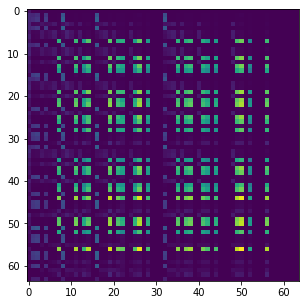

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(model_distribution_res['xy_hat'][:, :300])

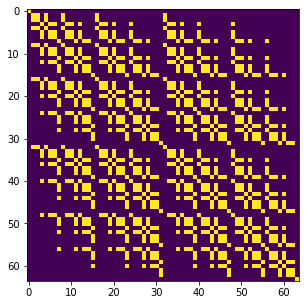

In [26]:
plt.figure(figsize = (5,5))
plt.imshow(xy[:, :300])

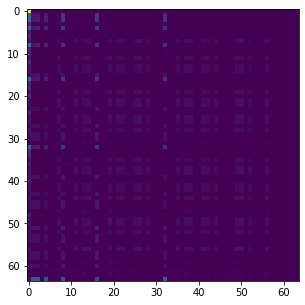

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(model_distribution_res['xy_div_xyind_hat'][:, :300])

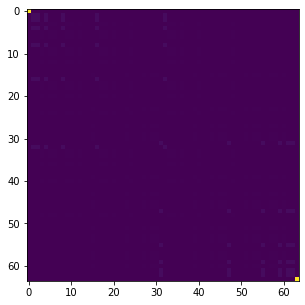

In [28]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy/xyind)[:, :300])